In [3]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
# from ydata_profiling import ProfileReport
import numpy as nps
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from scipy.stats import *

import warnings
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

In [4]:
#ponte de conexão com o redshift
#connection = psycopg2.connect(dbname="dw_amorsaude",
#                 user="",
#                 password="",
#                 host =".redshift.amazonaws.com",
#                  port = 5439)


In [5]:
json_manifest_dbt = "target/manifest.json"
athena_bucket = "todos-athena-us-east-1"
athena_tmp_folder = f"s3://{athena_bucket}/"

In [6]:
def execute_athena_sql(query):
    client = boto3.client('athena', region_name='us-east-1')
    queryStart = client.start_query_execution(
    QueryString = query,
    ResultConfiguration = { 'OutputLocation': athena_tmp_folder})
    queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])
    while queryExecution['QueryExecution']['Status']['State'] in ('RUNNING', 'QUEUED'):
        time.sleep(5)
        queryExecution = client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])

In [7]:
        def execute_athena_query(query):
    cursor = connect(s3_staging_dir=athena_tmp_folder,
                    region_name="us-east-1").cursor()
    cursor.execute(query)
    colls=','.join(str(f"{e[0]}") for e in cursor.description)
    results=pd.DataFrame(list(cursor), columns=colls.split(","))
    return results

In [8]:
# Carregando o arquivo Excel em um DataFrame
caminho_arquivo = '/home/lucasmateus/dbt-projects/projetos_lucas/projetos/anylogic/Relatorio_Atend Uberlandia - mês 09,10,11,12,01 e 02.xlsx'
nome_aba = 'Resultado Filtrado'
dfrelatorio_atendimento = pd.read_excel(caminho_arquivo, sheet_name=nome_aba)

In [9]:
dfrelatorio_atendimento['Unnamed: 10'] = dfrelatorio_atendimento['LOCAL'].str.split('-', n=1).str[0]
dfrelatorio_atendimento

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10
0,Cleiton Douglas Silva De Jesus [ Sair ],A15,DRA. CATIA FERNANDES MOREIRA,2023-09-25,15:02:24,00:03:51,00:12:49,00:16:40,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO
1,Gustavo Martins Da Silva,M114,ATENDIMENTO MEDICO,2023-10-06,14:51:45,00:17:34,00:03:22,00:20:56,Ivina Renata,GUICHÊS-01,GUICHÊS
2,Gustavo Martins Da Silva,M114,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-06,14:51:45,00:16:44,00:05:32,00:22:16,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO
3,Marina Goncalves Da Rosa,A7,DRA. CATIA FERNANDES MOREIRA,2023-09-18,09:53:33,00:01:11,00:43:40,00:44:51,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,CONSULTÓRIO
4,Poliana Adamis Goncalves Alexandre De Oliveira,M9,ATENDIMENTO MEDICO,2023-09-27,07:47:49,00:08:10,00:04:03,00:12:13,Ivina Renata,GUICHÊS-01,GUICHÊS
...,...,...,...,...,...,...,...,...,...,...,...
57403,NaN,M170,ATENDIMENTO MEDICO,2024-01-31,16:02:18,00:00:24,00:02:54,00:03:18,NaN,GUICHÊ-1,GUICHÊ
57404,NaN,E54,EXAMES,2024-01-31,16:09:45,00:00:28,00:12:38,00:13:06,RAMILA SILVA DE ARAUJO,GUICHÊ-3,GUICHÊ
57405,NaN,E55,EXAMES,2024-01-31,16:54:06,00:00:06,00:00:50,00:00:56,RAMILA SILVA DE ARAUJO,GUICHÊ-3,GUICHÊ
57406,NaN,EP6,EXAMES PREFERENCIAL,2024-01-31,17:35:45,00:01:19,00:22:29,00:23:48,RAMILA SILVA DE ARAUJO,GUICHÊ-3,GUICHÊ


In [10]:
# Selecione as colunas que você deseja converter para o tipo time
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

# Itere sobre as colunas selecionadas e converta para o tipo time
for coluna in colunas_tempo:
    dfrelatorio_atendimento[coluna] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time

In [11]:
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

for coluna in colunas_tempo:
    # Crie uma nova coluna com o sufixo '_decimal' para armazenar os valores convertidos
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_timedelta(dfrelatorio_atendimento[coluna + '_DECIMAL'].astype(str)).dt.total_seconds() / 3600.0

In [12]:
colunas_decimal = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

# Multiplique os valores por 60
dfrelatorio_atendimento[colunas_decimal] = dfrelatorio_atendimento[colunas_decimal].multiply(60)

In [13]:
#Retiro tudo que for acima de 60 minutos, indicando uma espera acima de 1 hora (outlier)

colunas_decimal = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

for coluna in colunas_decimal:
    dfrelatorio_atendimento = dfrelatorio_atendimento[dfrelatorio_atendimento[coluna] <= 60]

In [14]:
dfrelatorio_atendimento['EMISSAO_DECIMAL'] = dfrelatorio_atendimento['EMISSAO_DECIMAL'] / 60

In [15]:
# Verificar se há valores nulos em cada coluna
colunas_verificadas = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

for coluna in colunas_verificadas:
    tem_dados_vazios = dfrelatorio_atendimento[coluna].isnull().any()
    if tem_dados_vazios:
        print(f"A coluna '{coluna}' tem valores vazios.")
    else:
        print(f"A coluna '{coluna}' não tem valores vazios.")

A coluna 'EMISSAO_DECIMAL' não tem valores vazios.
A coluna 'TEMPO ESPERA_DECIMAL' não tem valores vazios.
A coluna 'TEMPO ATENDIMENTO_DECIMAL' não tem valores vazios.


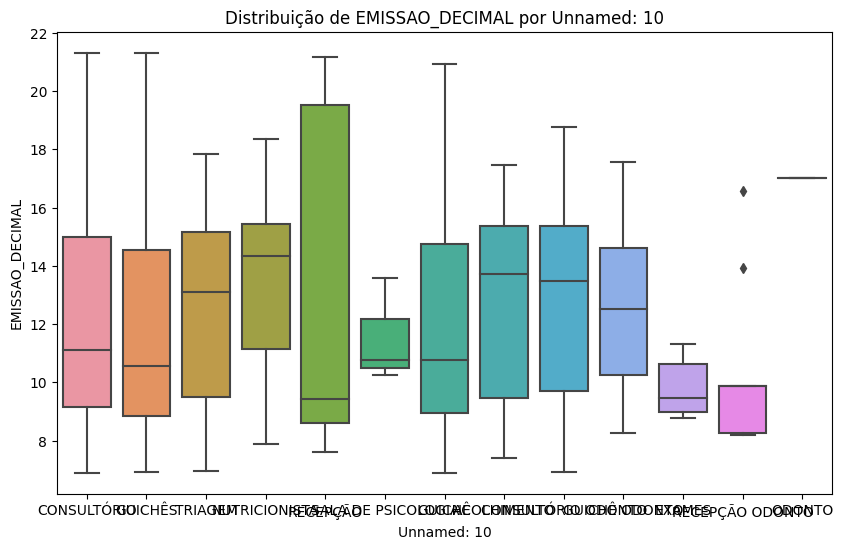

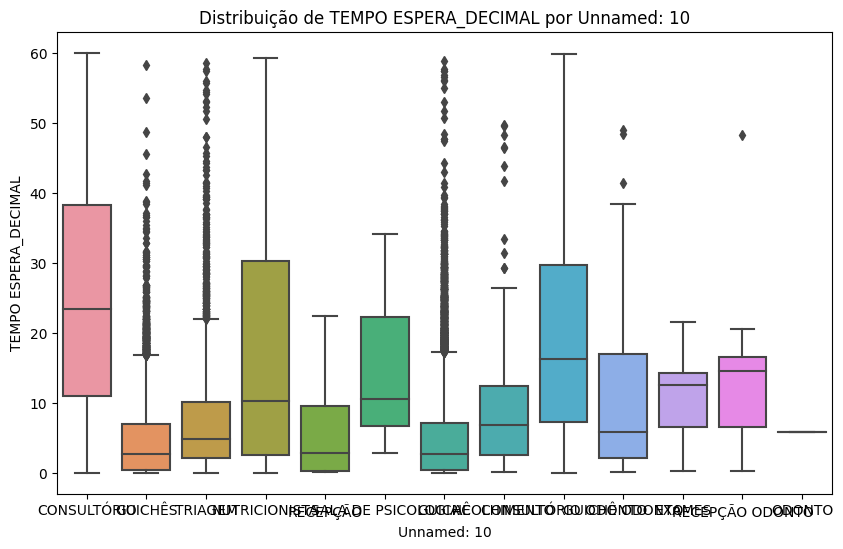

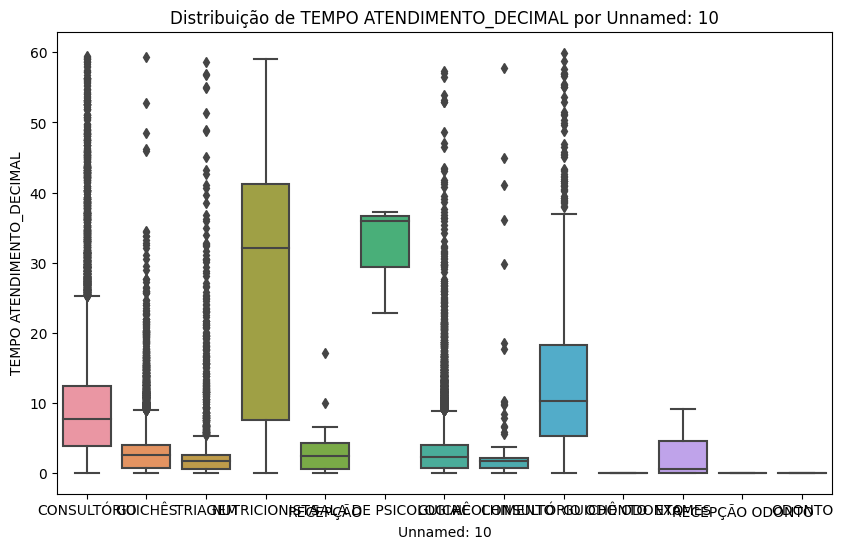

In [16]:
colunas_selecionadas = ['Unnamed: 10', 'EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = dfrelatorio_atendimento[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Unnamed: 10').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Unnamed: 10', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Unnamed: 10')
    plt.show()

In [17]:
estatisticas_descritivas

EMISSAO_DECIMAL                                             \
                             count       mean       std        min        25%   
Unnamed: 10                                                                     
ACOLHIMENTO                  187.0  12.614623  3.147938   7.401944   9.451667   
CONSULTÓRIO                15669.0  12.084668  3.244001   6.897222   9.169167   
CONSULTÓRIO ODONTO          1074.0  12.707661  3.094699   6.907778   9.713819   
EXAMES                        16.0   9.792934  0.937492   8.764722   8.972153   
GUICHÊ                     19703.0  11.746166  3.223710   6.897222   8.936111   
GUICHÊ ODONTO                 36.0  12.383835  2.665111   8.279167  10.253056   
GUICHÊS                    13288.0  11.585814  3.212731   6.913056   8.840278   
NUTRICIONISTA                159.0  13.572156  2.658140   7.896111  11.145694   
ODONTO                         1.0  17.000833       NaN  17.000833  17.000833   
RECEPÇÃO                      49.0  13.830726  5.633695   7.607500   8.598333   
RECEPÇÃO ODONTO                9.0  10.430432  2.906470   8.183611   8.249722   
SALA DE PSICOLOGIA             3.0  11.533426  1.802662  10.248889  10.503056   
TRIAGEM                     2600.0  12.432930  3.106907   6.954722   9.507986   

                                                    TEMPO ESPERA_DECIMAL  \
                          50%        75%        max                count   
Unnamed: 10                                                                
ACOLHIMENTO         13.730000  15.360139  17.449444                187.0   
CONSULTÓRIO         11.100833  15.002222  21.315000              15669.0   
CONSULTÓRIO ODONTO  13.481250  15.359167  18.775833               1074.0   
EXAMES               9.468750  10.617153  11.333333                 16.0   
GUICHÊ              10.781667  14.736250  20.936667              19703.0   
GUICHÊ ODONTO       12.521389  14.613958  17.563333                 36.0   
GUICHÊS             10.549583  14.552014  21.315000              13288.0   
NUTRICIONISTA       14.322778  15.445833  18.354444                159.0   
ODONTO              17.000833  17.000833  17.000833                  1.0   
RECEPÇÃO             9.437778  19.537500  21.163889                 49.0   
RECEPÇÃO ODONTO      9.870278   9.881111  16.585000                  9.0   
SALA DE PSICOLOGIA  10.757222  12.175694  13.594167                  3.0   
TRIAGEM             13.119167  15.146597  17.854722               2600.0   

                               ...                        \
                         mean  ...        75%        max   
Unnamed: 10                    ...                         
ACOLHIMENTO          9.533957  ...  12.375000  49.716667   
CONSULTÓRIO         25.277437  ...  38.300000  60.000000   
CONSULTÓRIO ODONTO  19.610583  ...  29.637500  59.883333   
EXAMES              11.254167  ...  14.229167  21.483333   
GUICHÊ               4.858900  ...   7.158333  58.766667   
GUICHÊ ODONTO       11.987963  ...  16.966667  48.900000   
GUICHÊS              4.470367  ...   6.966667  58.300000   
NUTRICIONISTA       17.935115  ...  30.241667  59.216667   
ODONTO               5.883333  ...   5.883333   5.883333   
RECEPÇÃO             5.537755  ...   9.583333  22.366667   
RECEPÇÃO ODONTO     15.250000  ...  16.550000  48.216667   
SALA DE PSICOLOGIA  15.838889  ...  22.316667  34.150000   
TRIAGEM              7.774936  ...  10.066667  58.533333   

                   TEMPO ATENDIMENTO_DECIMAL                               \
                                       count       mean        std    min   
Unnamed: 10                                                                 
ACOLHIMENTO                            187.0   2.978342   7.085702   0.00   
CONSULTÓRIO                          15669.0   9.230828   8.679680   0.00   
CONSULTÓRIO ODONTO                    1074.0  13.239246  11.636359   0.00   
EXAMES                                  16.0   2.519792   3.382226   0.00   
GUICH

<Figure size 1000x1600 with 0 Axes>

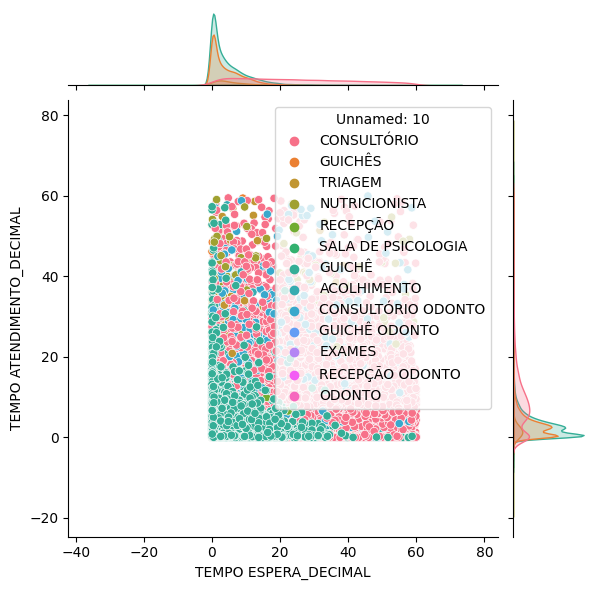

In [18]:
colunas_selecionadas = ['Unnamed: 10', 'EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = dfrelatorio_atendimento[colunas_selecionadas]
#df_filtrado = df_selecionado[df_selecionado['Unnamed: 10'] == 'CONSULTÓRIO']

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
plt.figure(figsize=(10, 16))
sns.jointplot(y='TEMPO ATENDIMENTO_DECIMAL', x='TEMPO ESPERA_DECIMAL', data=df_selecionado, hue="Unnamed: 10")

plt.show()

In [19]:
from scipy.stats import kstest
from scipy.stats import norm, expon, gamma, weibull_min, beta,  erlang, cauchy, laplace, logistic, rayleigh, uniform, triang

# pareto #chi2

#Cria uma função para retornar a melhor distribuição:

def analisar_distribuicoes_por_local(df, colunas_decimais, grupo_coluna='Unnamed: 10'):
    for coluna_decimal in colunas_decimais:
        plt.figure(figsize=(10, 6))
        sns.histplot(df, x=coluna_decimal, hue=grupo_coluna, kde=True, common_norm=False)
        plt.title(f'Distribuição de {coluna_decimal} agrupada por {grupo_coluna}')
        plt.show()

    distribuicoes = [norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang]

    for coluna_decimal in colunas_decimais:
        print(f"=== Resultados para {coluna_decimal} ===")
        for grupo, dados in df.groupby(grupo_coluna)[coluna_decimal]:
            melhor_distribuicao = None
            melhor_pvalue = float('inf')

            for distribuicao in distribuicoes:
                args = distribuicao.fit(dados)
                ks_statistic, pvalue = kstest(dados, distribuicao.cdf, args)

                if pvalue < melhor_pvalue:
                    melhor_pvalue = pvalue
                    melhor_distribuicao = distribuicao

            print(f"Grupo {grupo} - Melhor distribuição: {melhor_distribuicao.name}")
            print("Parâmetros da distribuição:", melhor_distribuicao.fit(dados))
            print("Estatísticas descritivas:")

In [20]:
from scipy.stats import kstest
from scipy.stats import norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang

def analisar_distribuicoes_por_atendente2(df, colunas_decimais, coluna_grupo='Especialidade', distribuicoes=None):
    if distribuicoes is None:
        distribuicoes = [norm, expon, gamma, weibull_min, beta, erlang, cauchy, laplace, logistic, rayleigh, uniform, triang]

    for coluna_decimal in colunas_decimais:
        plt.figure(figsize=(10, 6))
        #sns.histplot(df, x=coluna_decimal, hue=coluna_grupo, kde=True, stat="probability", thresh=None, discrete=(True, False), common_norm=False)
        sns.kdeplot(
        data=df, x=coluna_decimal, hue=coluna_grupo,
        fill=True, common_norm=False, palette="crest",
        alpha=.5, linewidth=0,)
        plt.title(f'Distribuição de {coluna_decimal} agrupada por {coluna_grupo}')
        plt.show()

    for coluna_decimal in colunas_decimais:
        print(f"=== Resultados para {coluna_decimal} ===")
        for grupo, dados in df.groupby(coluna_grupo)[coluna_decimal]:
            melhor_distribuicao = None
            melhor_pvalue = float('inf')

            for distribuicao in distribuicoes:
                # Ajuste da distribuição
                args = distribuicao.fit(dados)
                ks_statistic, pvalue = kstest(dados, distribuicao.cdf, args)

                if pvalue < melhor_pvalue:
                    melhor_pvalue = pvalue
                    melhor_distribuicao = distribuicao

            print(f"{coluna_grupo} {grupo} - Melhor distribuição: {melhor_distribuicao.name}")
            print("Parâmetros da distribuição:", melhor_distribuicao.fit(dados))  # Agora, mostra os parâmetros do melhor ajuste
            print("Estatísticas descritivas:")
            print(dados.describe())  # Adiciona estatísticas descritivas
            print("\n")

In [21]:
# Aplicando o filtro de recepção
df_filtro_recepcao = dfrelatorio_atendimento[(dfrelatorio_atendimento['TIPO ATENDIMENTO'] == 'ATENDIMENTO MEDICO') & (dfrelatorio_atendimento['Unnamed: 10'].isin(['GUICHÊS', 'RECEPCAO']))]
#filtro de triagem
df_filtro_triagem = dfrelatorio_atendimento[dfrelatorio_atendimento['TIPO ATENDIMENTO'].str.startswith(('DR.', 'DRA.')) & (dfrelatorio_atendimento['Unnamed: 10'] == 'TRIAGEM')]
# Aplicando o filtro separando o médico e sua especialidade
df_filtro_consultorio = dfrelatorio_atendimento[dfrelatorio_atendimento['TIPO ATENDIMENTO'].str.startswith(('DR.', 'DRA.')) & (dfrelatorio_atendimento['Unnamed: 10'] == 'CONSULTÓRIO')]

#retirado EMISSAO DECIMAL
colunas_decimais = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

#retiro tudo que é menos que 4 minutos de atendimento dentro do df de médicos
for coluna in colunas_decimal:
    df_filtro_consultorio = df_filtro_consultorio[df_filtro_consultorio[coluna] >= 4]

In [22]:
# Lista de nomes de atendentes desejados
nomes_atendentes = [
    'Dr. Fransergio Ferreira',
    'Dra. Ludimila Viana',
    'Dra. Angela Fernandes',
    'Dra. Annelise de Macedo',
    'Dr. Enzo Borges',
    'Dra. Isabella Bastos',
    'Dr. Renato Leoni',
    'Dra. Leticia Maia',
    'Dra.Izabella Cunha Campos',
    'Dra. Roseli Maria De Oliveira Carvalho ',
    'Dr. Walter Tadeu',
    'Dr. Diego Umberto De Mendonca Biasi'
]

# Dicionário de mapeamento entre nomes de atendentes e especialidades
mapeamento_especialidades = {
    'Dr. Fransergio Ferreira': 'Clínica Médica',
    'Dra. Ludimila Viana': 'Clínica Médica',
    'Dra. Angela Fernandes': 'Clínica Médica',
    'Dra. Annelise de Macedo': 'Oftalmo',
    'Dr. Enzo Borges': 'Oftalmo',
    'Dra. Isabella Bastos': 'Oftalmo',
    'Dr. Renato Leoni': 'G.O',
    'Dra. Leticia Maia': 'G.O',
    'Dra.Izabella Cunha Campos': 'G.O',
    'Dra. Roseli Maria De Oliveira Carvalho ': 'Cardio',
    'Dr. Walter Tadeu': 'Cardio',
    'Dr. Diego Umberto De Mendonca Biasi': 'Dermato'
}

# Criando a nova coluna 'Especialidade' com base no mapeamento
df_filtro_consultorio['Especialidade'] = df_filtro_consultorio['ATENDENTE'].map(mapeamento_especialidades)

contagem_por_atendente_especialidade = df_filtro_consultorio.groupby(['ATENDENTE', 'Especialidade']).size().reset_index(name='Contagem')
print(contagem_por_atendente_especialidade)

                              ATENDENTE   Especialidade  Contagem
0   Dr. Diego Umberto De Mendonca Biasi         Dermato       226
1                       Dr. Enzo Borges         Oftalmo       626
2               Dr. Fransergio Ferreira  Clínica Médica      1993
3                      Dr. Renato Leoni             G.O       200
4                      Dr. Walter Tadeu          Cardio        92
5                 Dra. Angela Fernandes  Clínica Médica        64
6               Dra. Annelise de Macedo         Oftalmo       791
7                  Dra. Isabella Bastos         Oftalmo        16
8                     Dra. Leticia Maia             G.O       272
9                   Dra. Ludimila Viana  Clínica Médica       220
10            Dra.Izabella Cunha Campos             G.O       350


In [23]:
df_filtro_consultorio

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
2,Gustavo Martins Da Silva,M114,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-06,14:51:45,00:16:44,00:05:32,00:22:16,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO,14.862500,16.733333,5.533333,NaN
7,\tabadia De Fatima Ramos Dos Santos,M175,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-13,14:47:19,00:06:36,00:04:30,00:11:06,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-2,CONSULTÓRIO,14.788611,6.600000,4.500000,Dermato
19,\tadriana Paula Dos Santos,M166,DRA. ANNELISE DE MACEDO,2023-09-26,14:24:05,00:53:56,00:13:30,01:07:26,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,14.401389,53.933333,13.500000,Oftalmo
21,\tadriano Leal Faria,M73,DRA. ANNELISE DE MACEDO,2023-10-23,09:33:45,00:51:34,00:09:23,01:00:57,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,9.562500,51.566667,9.383333,Oftalmo
26,\taldeir De Castro Souza,M48,DR.FRANSERGIO FERREIRA,2023-10-30,13:25:34,00:14:19,00:12:03,00:26:22,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,13.426111,14.316667,12.050000,Clínica Médica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53747,bianka De Orleans Germano,M129,DR. ENZO BORGES,2024-01-24,13:09:51,00:48:04,00:07:41,00:55:45,Dr. Enzo Borges,CONSULTÓRIO-7,CONSULTÓRIO,13.164167,48.066667,7.683333,Oftalmo
53749,augusta Sobral,P16,DRA. VICTORIA FRANCO GONÇALVES,2024-01-18,18:48:54,00:45:16,00:06:02,00:51:18,Dra. Victoria Franco Gonçalves,CONSULTÓRIO-7,CONSULTÓRIO,18.815000,45.266667,6.033333,NaN
53751,antonia Alves Nunes Moura,P9,DR.FRANSERGIO FERREIRA,2024-01-27,10:32:53,00:07:13,00:12:50,00:20:03,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,10.548056,7.216667,12.833333,Clínica Médica
53753,ana Luiza Zacharias Silveira,M183,DR. ENZO BORGES,2024-01-15,15:17:58,00:48:08,00:07:48,00:55:56,Dr. Enzo Borges,CONSULTÓRIO-7,CONSULTÓRIO,15.299444,48.133333,7.800000,Oftalmo


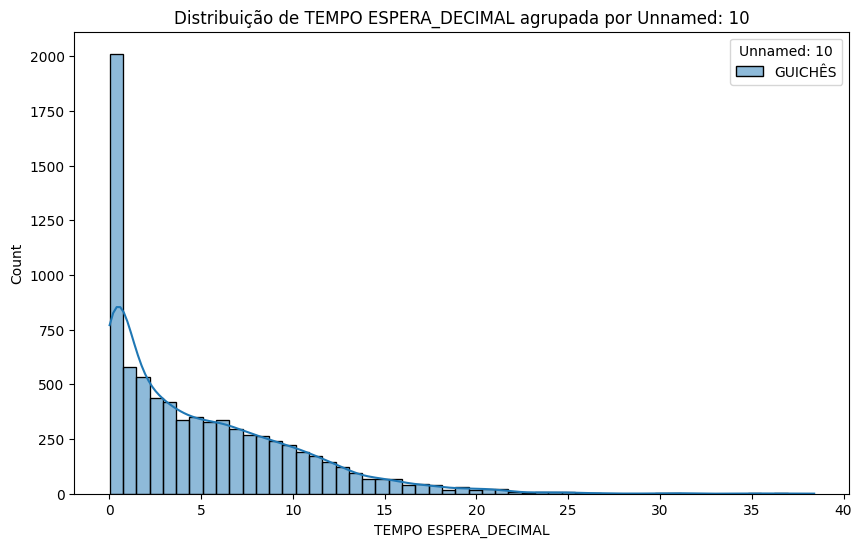

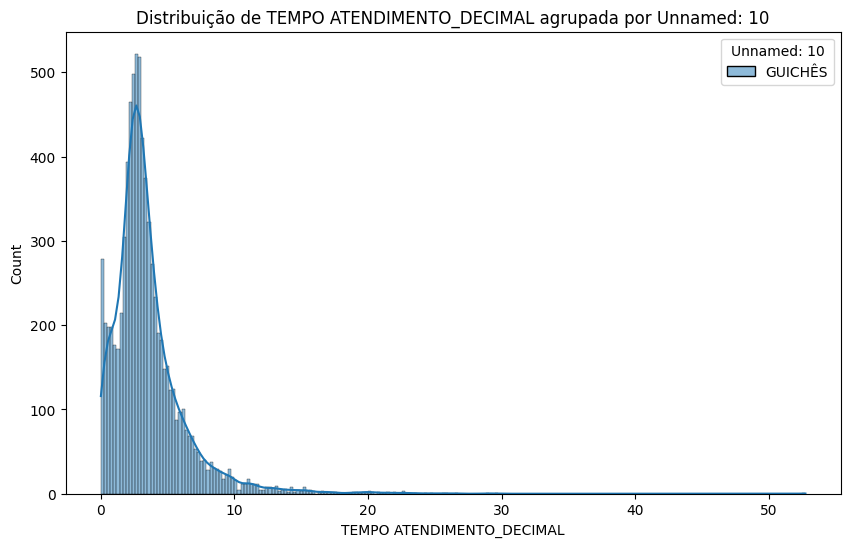

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo GUICHÊS - Melhor distribuição: cauchy
Parâmetros da distribuição: (2.846174284278143, 2.693050137599691)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo GUICHÊS - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.8443569763952572, -4.8182328692093446e-27, 2.3640372674772685)
Estatísticas descritivas:


In [24]:
analisar_distribuicoes_por_local(df_filtro_recepcao, colunas_decimais)

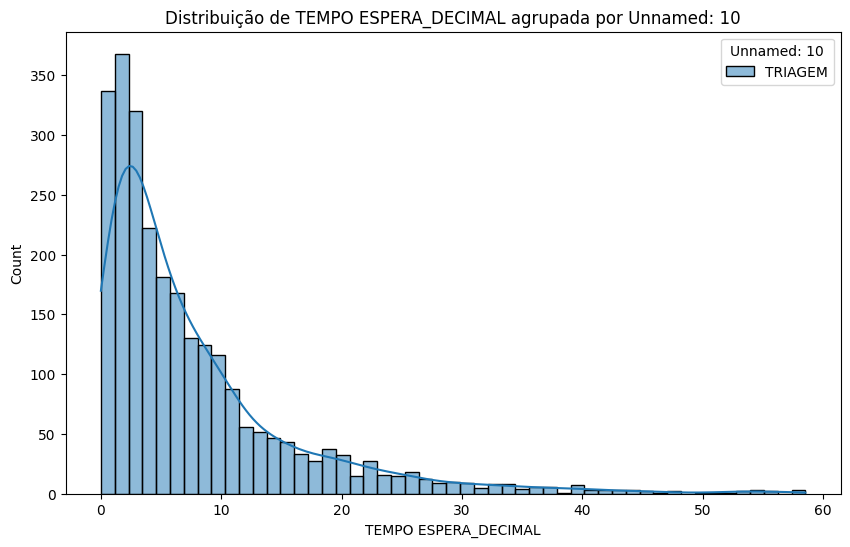

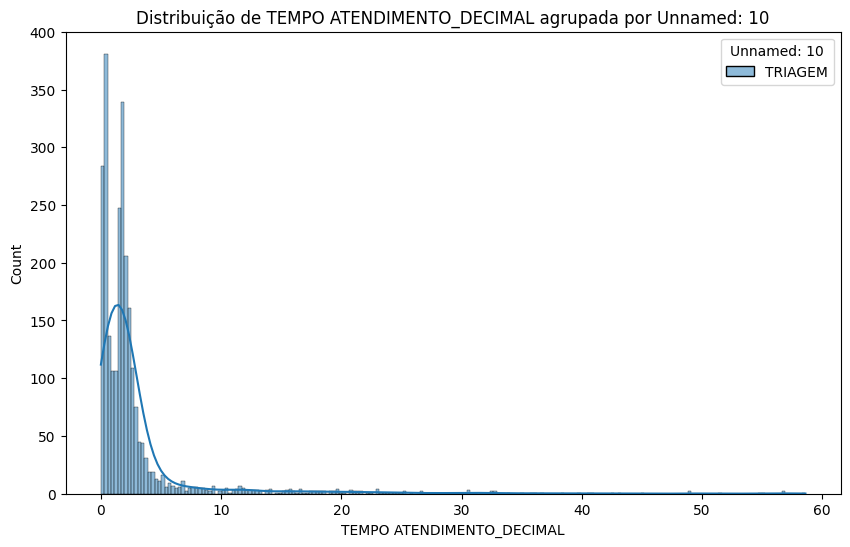

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo TRIAGEM - Melhor distribuição: erlang
Parâmetros da distribuição: (0.001759805783034822, -1.067920056771907e-27, 2.436550006791374)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo TRIAGEM - Melhor distribuição: gamma
Parâmetros da distribuição: (0.19131836711253064, -6.197029827683994e-28, 1.5399880644960828)
Estatísticas descritivas:


In [25]:
analisar_distribuicoes_por_local(df_filtro_triagem, colunas_decimais)

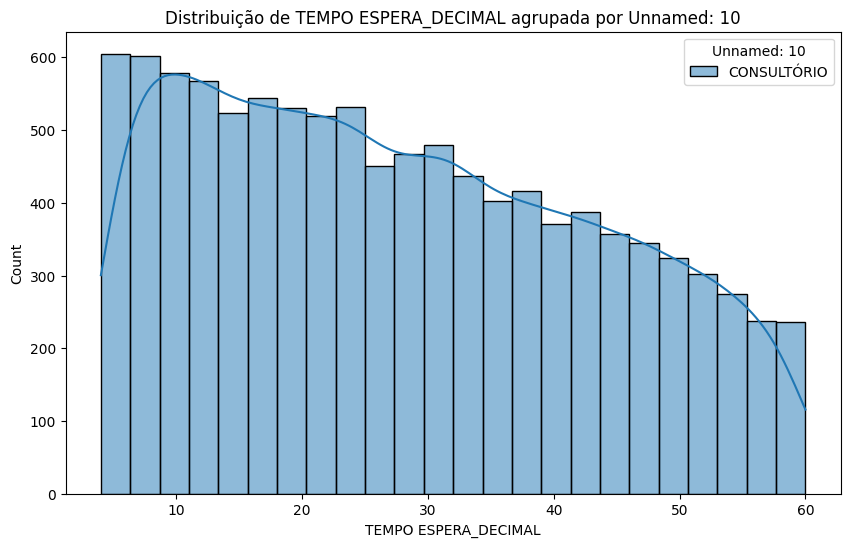

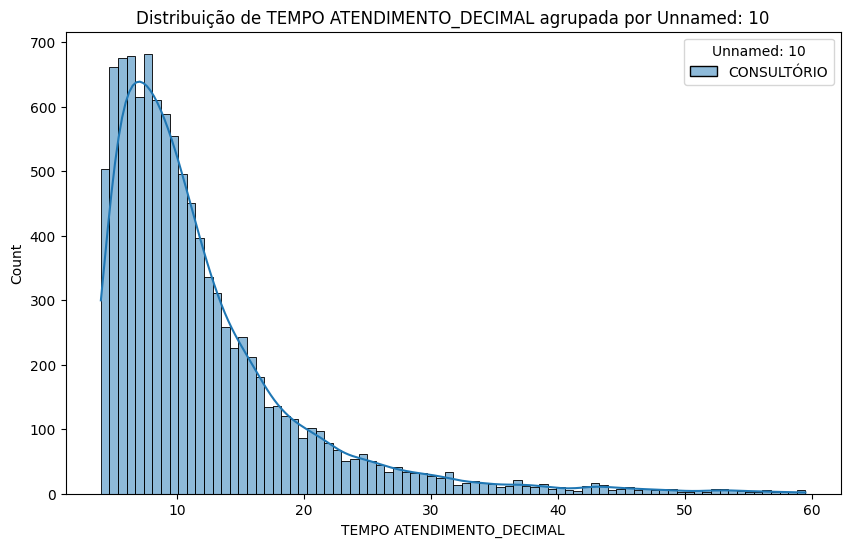

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: cauchy
Parâmetros da distribuição: (25.438470056500506, 10.962175902131799)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: uniform
Parâmetros da distribuição: (4.0, 55.46666666666667)
Estatísticas descritivas:


In [26]:
analisar_distribuicoes_por_local(df_filtro_consultorio, colunas_decimais)

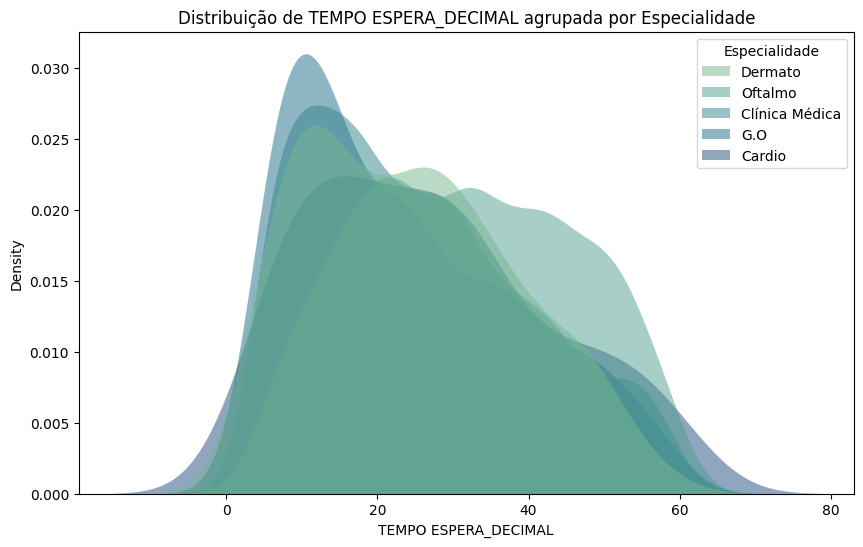

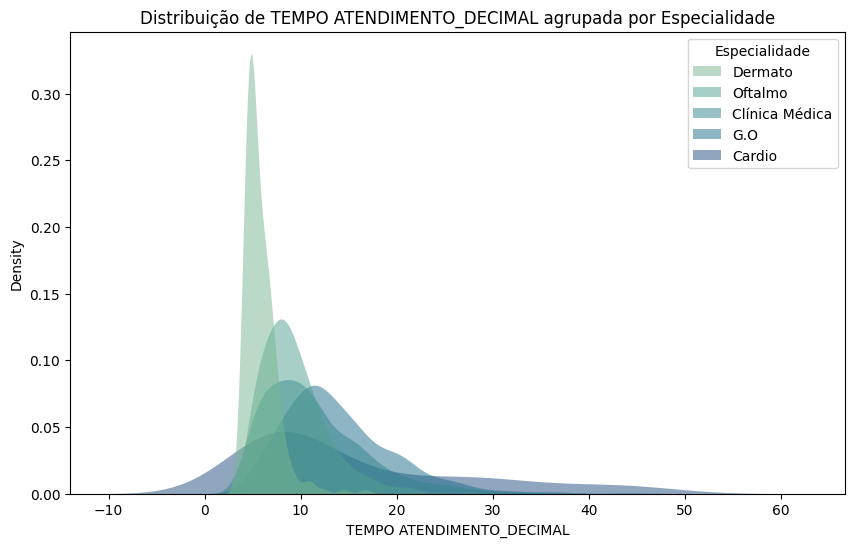

=== Resultados para TEMPO ESPERA_DECIMAL ===
Especialidade Cardio - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.7789054728127202, 4.033333333333332, 11.087119162431438)
Estatísticas descritivas:
count    92.000000
mean     26.815036
std      15.564428
min       4.033333
25%      14.087500
50%      25.383333
75%      35.987500
max      59.483333
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Clínica Médica - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.6700573679914588, 3.9999999999999996, 7.993115039721393)
Estatísticas descritivas:
count    2277.000000
mean       25.119953
std        14.545644
min         4.000000
25%        12.816667
50%        22.866667
75%        35.483333
max        59.933333
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Dermato - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.832391182987253, 4.05, 10.884003370063844)
Estatísticas descritivas:
count    226.000000
mean      24.389012


In [27]:
analisar_distribuicoes_por_atendente2(df_filtro_consultorio ,colunas_decimais)

Tentando entender os valores acima ou abaixo do normal dos dados

In [28]:
#Começando pelos valores anormais da especialidade cardiologista

df_filtrado_consultorio_cardio = df_filtro_consultorio.loc[df_filtro_consultorio['Especialidade'] == 'Cardio']
df_filtrado_consultorio_cardio = df_filtrado_consultorio_cardio.reset_index(drop=True)

In [29]:
descritivas = df_filtrado_consultorio_cardio.describe()
print(descritivas)

       EMISSAO_DECIMAL  TEMPO ESPERA_DECIMAL  TEMPO ATENDIMENTO_DECIMAL
count        92.000000             92.000000                  92.000000
mean          8.794293             26.815036                  15.821014
std           0.928976             15.564428                  11.941444
min           7.084722              4.033333                   4.150000
25%           7.999236             14.087500                   6.820833
50%           8.681528             25.383333                  10.550000
75%           9.325347             35.987500                  22.887500
max          11.367500             59.483333                  48.533333


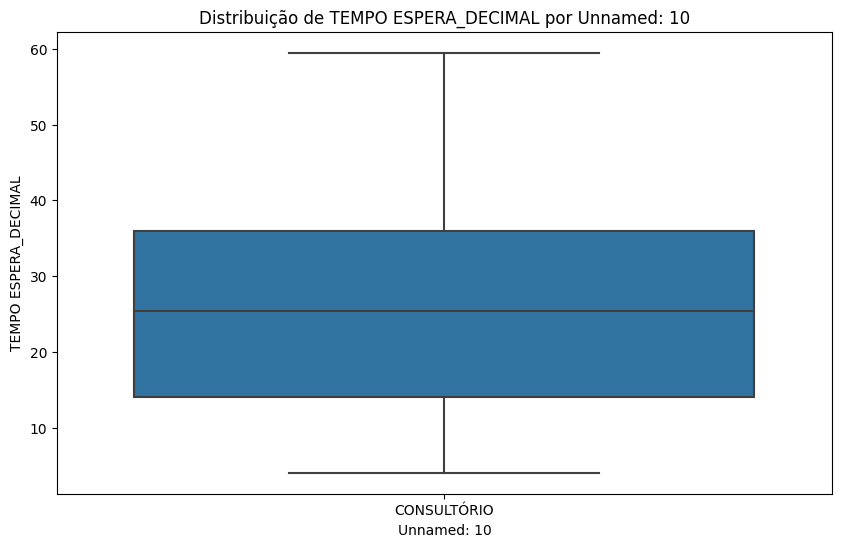

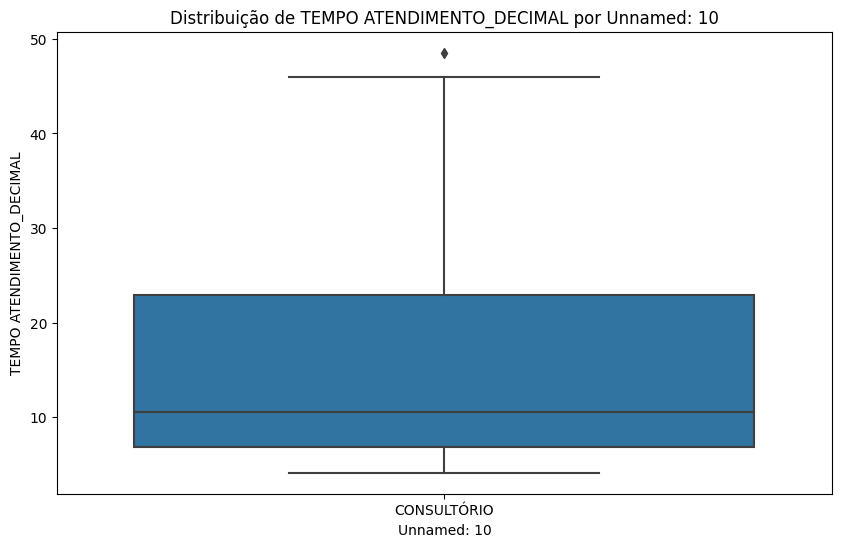

In [30]:
colunas_selecionadas = ['Unnamed: 10', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = df_filtrado_consultorio_cardio[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Unnamed: 10').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Unnamed: 10', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Unnamed: 10')
    plt.show()

In [31]:
# Filtrar linhas com TEMPO ATENDIMENTO_DECIMAL abaixo de 20
df_abaixo_20 = df_filtrado_consultorio_cardio[df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] < 20]
# Filtrar linhas com TEMPO ATENDIMENTO_DECIMAL igual ou acima de 20
df_acima_ou_igual_20 = df_filtrado_consultorio_cardio[df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] >= 20]

In [32]:
# Contagem para valores abaixo de 20
contagem_abaixo_20 = (df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] < 20).sum()
# Contagem para valores acima de 40
contagem_acima_20 = (df_filtrado_consultorio_cardio['TEMPO ATENDIMENTO_DECIMAL'] > 20).sum()

In [33]:
percent = contagem_abaixo_20 + contagem_acima_20
percent20 = (contagem_abaixo_20/percent)*100
percentacima20 = (contagem_acima_20/percent)*100
percentotal = percent20 + percent20

print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade abaixo de 20:", contagem_abaixo_20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade acima de 20:", contagem_acima_20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual abaixo de 20:", percent20)
print("Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual acima de 20:", percentacima20)

Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade abaixo de 20: 65
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL quantidade acima de 20: 27
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual abaixo de 20: 70.65217391304348
Quantidade de linhas com TEMPO ATENDIMENTO_DECIMAL percentual acima de 20: 29.347826086956523


In [34]:
df_acima_ou_igual_20

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
0,\tana Paula Leao Dos Santos,M21,DR. WALTER TADEU,2023-09-12,08:27:34,00:06:13,00:42:44,00:48:57,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.459444,6.216667,42.733333,Cardio
3,Adner Augusto Gomes,M8,DR. WALTER TADEU,2023-09-16,08:06:11,00:07:43,00:20:05,00:27:48,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.103056,7.716667,20.083333,Cardio
4,Adriana Goncalves De Oliveira,M8,DR. WALTER TADEU,2023-09-22,08:13:54,00:04:02,00:43:10,00:47:12,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.231667,4.033333,43.166667,Cardio
14,Domingas Neres Da Silva,M12,DR. WALTER TADEU,2023-10-03,07:51:18,00:43:14,00:25:04,01:08:18,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,7.855000,43.233333,25.066667,Cardio
16,Elisama Torres Da Silva,M17,DR. WALTER TADEU,2023-10-27,08:27:18,00:51:50,00:24:06,01:15:56,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.455000,51.833333,24.100000,Cardio
19,Gladston Vieira Costa,M42,DR. WALTER TADEU,2023-09-05,09:33:47,00:29:29,00:26:10,00:55:39,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,9.563056,29.483333,26.166667,Cardio
21,Helenice Maria Maximo,M82,DR. WALTER TADEU,2023-10-03,10:19:50,00:17:28,00:32:08,00:49:36,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,10.330556,17.466667,32.133333,Cardio
28,Jose Avila Dos Santos,P3,DR. WALTER TADEU,2023-10-04,07:59:27,00:37:05,00:36:07,01:13:12,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,7.990833,37.083333,36.116667,Cardio
33,Laurencia Santana,M19,DR. WALTER TADEU,2023-09-26,08:05:15,00:46:23,00:26:04,01:12:27,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.087500,46.383333,26.066667,Cardio
43,Olingio Alves Neponuceno,M38,DR. WALTER TADEU,2023-10-24,08:31:33,00:14:53,00:33:41,00:48:34,Dr. Walter Tadeu,CONSULTÓRIO-3,CONSULTÓRIO,8.525833,14.883333,33.683333,Cardio


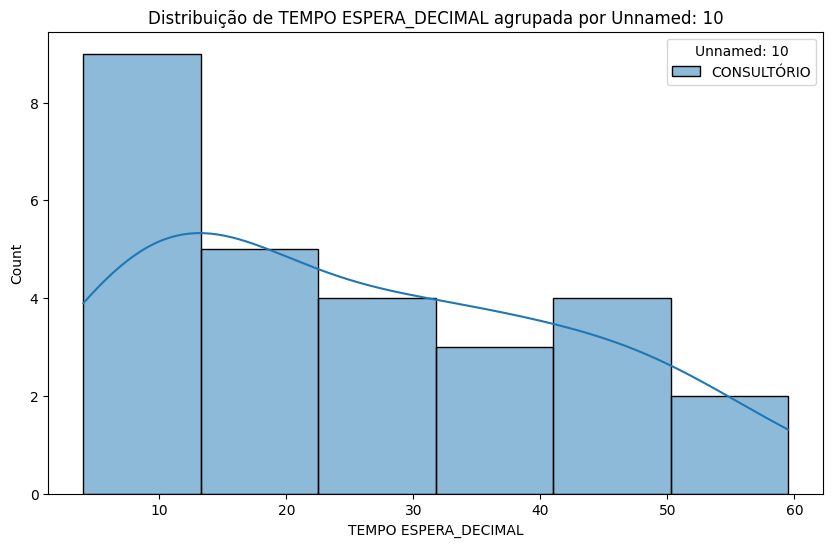

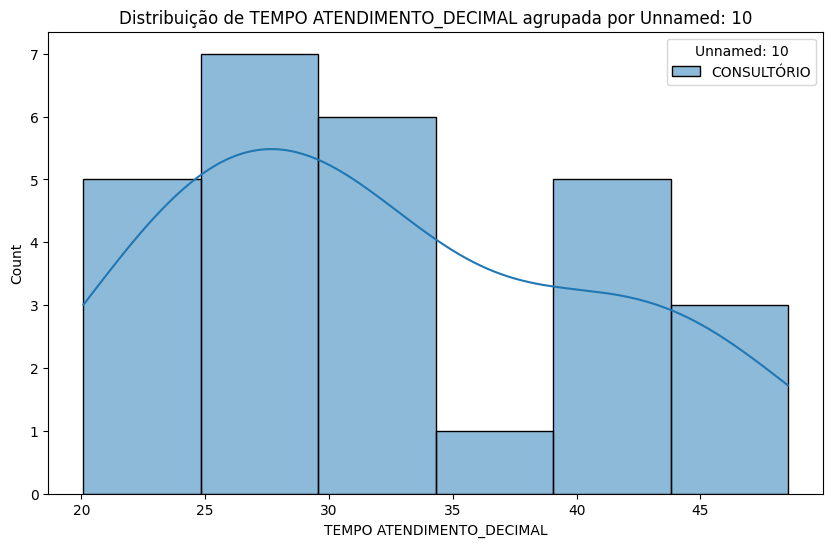

=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.6585663133706146, 4.033333333333332, 8.320126172113609)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo CONSULTÓRIO - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.3600513064970072, 20.08333333333333, 1.355781312785557)
Estatísticas descritivas:


In [35]:
analisar_distribuicoes_por_local(df_acima_ou_igual_20, colunas_decimais)

GERANDO OS DF COM BASE NOS TEMPOS ENVIADO

In [36]:
import pandas as pd

# Supondo que você tenha um DataFrame df_filtro_consultorio

# Condições para filtrar
condicoes_filtro = {
    'Cardio': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 20),
    'Clínica Médica': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 18),
    'Oftalmo': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 19.5),
    'G.O': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 26.7),
    'Dermato': (df_filtro_consultorio['TEMPO ATENDIMENTO_DECIMAL'] <= 19),
}

# Aplicar as condições de filtro para cada especialidade
df_filtrado = pd.DataFrame()
for especialidade, condicao in condicoes_filtro.items():
    df_especialidade = df_filtro_consultorio[condicao]
    df_especialidade['Especialidade'] = especialidade
    df_filtrado = pd.concat([df_filtrado, df_especialidade])

df_filtrado

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,Especialidade
2,Gustavo Martins Da Silva,M114,DR. EDUARDO MIGUEL NOGUEIRA BARROS,2023-10-06,14:51:45,00:16:44,00:05:32,00:22:16,Dr. Eduardo Miguel Nogueira Barros,CONSULTÓRIO-6,CONSULTÓRIO,14.862500,16.733333,5.533333,Cardio
7,\tabadia De Fatima Ramos Dos Santos,M175,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-13,14:47:19,00:06:36,00:04:30,00:11:06,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-2,CONSULTÓRIO,14.788611,6.600000,4.500000,Cardio
19,\tadriana Paula Dos Santos,M166,DRA. ANNELISE DE MACEDO,2023-09-26,14:24:05,00:53:56,00:13:30,01:07:26,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,14.401389,53.933333,13.500000,Cardio
21,\tadriano Leal Faria,M73,DRA. ANNELISE DE MACEDO,2023-10-23,09:33:45,00:51:34,00:09:23,01:00:57,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,9.562500,51.566667,9.383333,Cardio
26,\taldeir De Castro Souza,M48,DR.FRANSERGIO FERREIRA,2023-10-30,13:25:34,00:14:19,00:12:03,00:26:22,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,13.426111,14.316667,12.050000,Cardio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53747,bianka De Orleans Germano,M129,DR. ENZO BORGES,2024-01-24,13:09:51,00:48:04,00:07:41,00:55:45,Dr. Enzo Borges,CONSULTÓRIO-7,CONSULTÓRIO,13.164167,48.066667,7.683333,Dermato
53749,augusta Sobral,P16,DRA. VICTORIA FRANCO GONÇALVES,2024-01-18,18:48:54,00:45:16,00:06:02,00:51:18,Dra. Victoria Franco Gonçalves,CONSULTÓRIO-7,CONSULTÓRIO,18.815000,45.266667,6.033333,Dermato
53751,antonia Alves Nunes Moura,P9,DR.FRANSERGIO FERREIRA,2024-01-27,10:32:53,00:07:13,00:12:50,00:20:03,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,10.548056,7.216667,12.833333,Dermato
53753,ana Luiza Zacharias Silveira,M183,DR. ENZO BORGES,2024-01-15,15:17:58,00:48:08,00:07:48,00:55:56,Dr. Enzo Borges,CONSULTÓRIO-7,CONSULTÓRIO,15.299444,48.133333,7.800000,Dermato


In [38]:
#exportar para excel para validação
# caminho_arquivo_excel = '/home/gabriel/dbt-projects/python_files/analises/notebooks/dffiltrado.xlsx'

# Exporte o DataFrame para o Excel
# df_filtrado.to_excel(caminho_arquivo_excel, index=False)  # index=False para não incluir o índice do DataFrame no arquivo Excel

In [39]:
# Supondo que 'Especialidade' seja o nome da coluna que contém as especialidades no seu DataFrame
contagem_por_especialidade = df_filtro_consultorio['Especialidade'].value_counts()

# Exibindo a contagem total por especialidade
print(contagem_por_especialidade)

Clínica Médica    2277
Oftalmo           1433
G.O                822
Dermato            226
Cardio              92
Name: Especialidade, dtype: int64


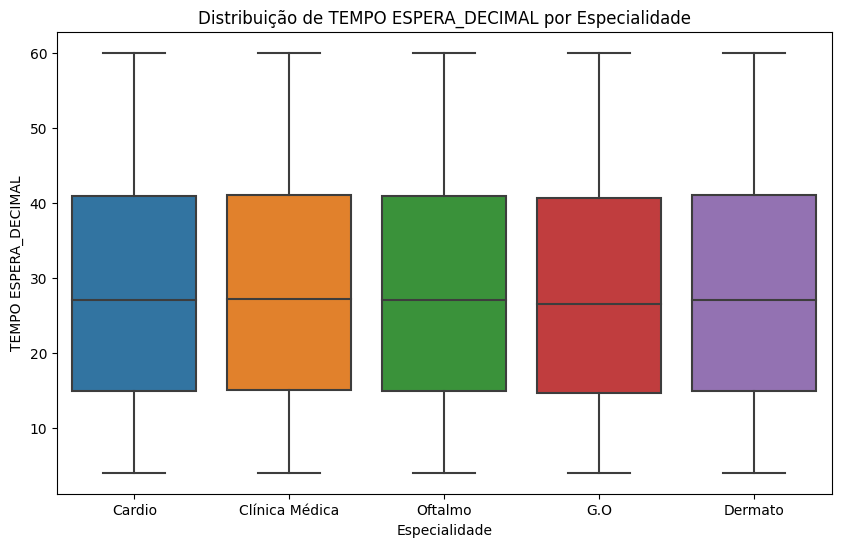

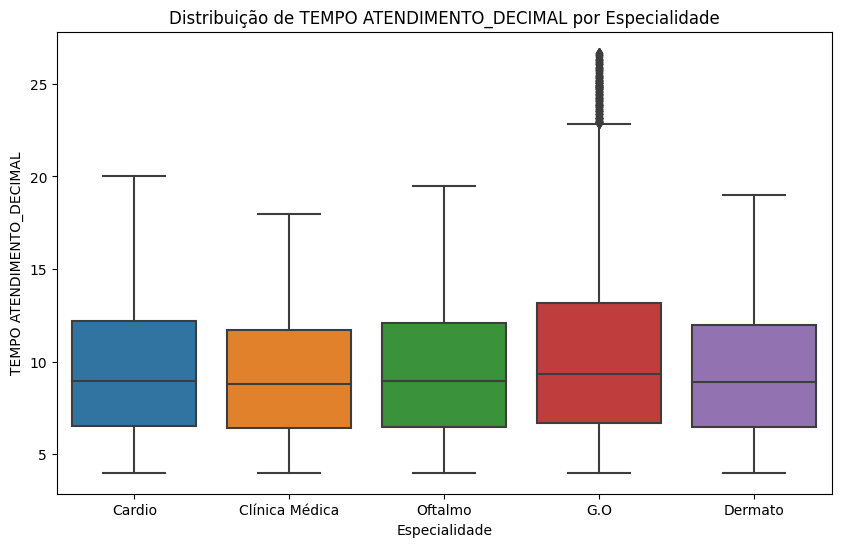

In [40]:
colunas_selecionadas = ['Especialidade', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = df_filtrado[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Especialidade').describe()

# Exiba a tabela de estatísticas descritivas
estatisticas_descritivas

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Especialidade', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Especialidade')
    plt.show()

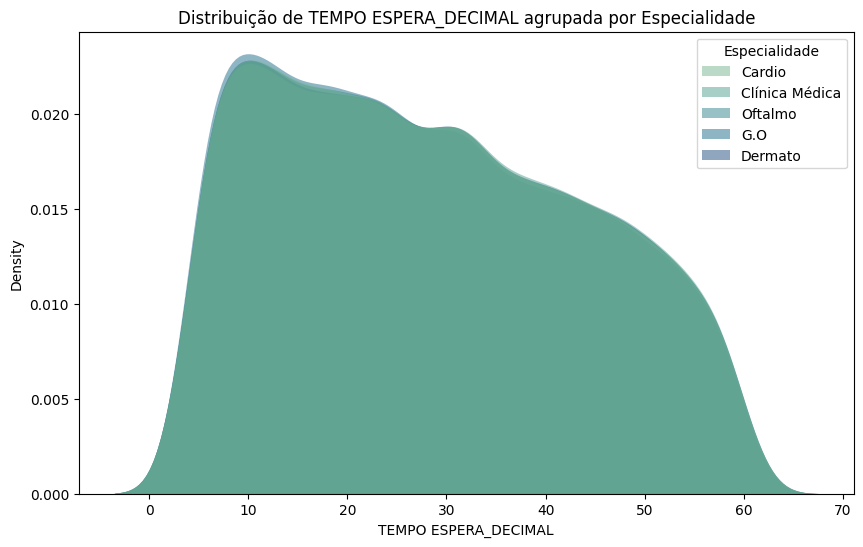

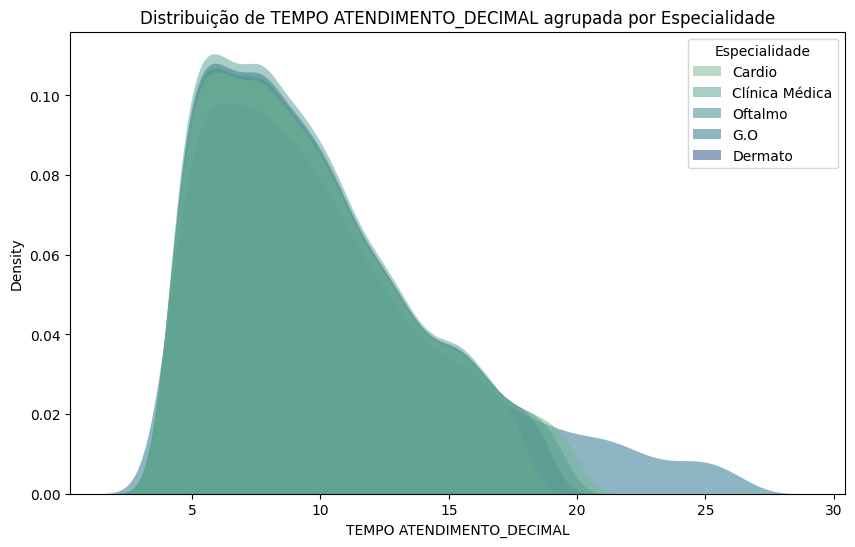

=== Resultados para TEMPO ESPERA_DECIMAL ===
Especialidade Cardio - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.6541602589054483, 3.9999999999999996, 8.720726586201543)
Estatísticas descritivas:
count    9255.000000
mean       28.331498
std        15.471995
min         4.000000
25%        14.933333
50%        26.966667
75%        40.916667
max        60.000000
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Clínica Médica - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.6730085202938112, 3.999999999999999, 8.60967677312831)
Estatísticas descritivas:
count    8916.000000
mean       28.441188
std        15.498766
min         4.000000
25%        14.979167
50%        27.200000
75%        41.054167
max        60.000000
Name: TEMPO ESPERA_DECIMAL, dtype: float64


Especialidade Dermato - Melhor distribuição: weibull_min
Parâmetros da distribuição: (0.6531792100639844, 3.999999999999999, 8.722091577421837)
Estatísticas descritivas:
count    9093

In [41]:
a = analisar_distribuicoes_por_atendente2(df_filtrado, colunas_decimais)

Abaixo é uma tentativa de gerar uma referência com os profissionais e o conta a receber, buscando sua especialidade e vínculando o mesmo a feegow

In [42]:
df_cr = ('''
         select tccarhn.nome_paciente as CLIENTE, tccarhn.nome_procedimento, tccarhn.datapagamento 
from pdgt_amorsaude_financeiro.fl_contas_a_receber tccarhn
where 1=1
and tccarhn.nome_procedimento like 'Consult%'
and tccarhn.nome_unidade = 'AmorSaúde Uberlândia'
''')

In [43]:
#df = execute_athena_query(df_cr)

In [44]:
novos_nomes = ['CLIENTE', 'PROCEDIMENTO', 'DATA']
df.columns = novos_nomes
df.dtypes

NameError: name 'df' is not defined

In [ ]:
df1, df2, df3 = df

In [ ]:
df['DATA'] = pd.to_datetime(df['DATA'])
df.dtypes

CLIENTE                 object
PROCEDIMENTO            object
DATA            datetime64[ns]
dtype: object

In [ ]:
import re
import pandas as pd

# Função para remover caracteres especiais (exceto espaços)
def remover_caracteres_especiais(nome):
    if isinstance(nome, str):
        return re.sub(r'[^A-Za-z0-9 ]', '', nome)
    else:
        return nome

# Aplicar a função à coluna 'CLIENTE'
df['CLIENTE'] = df['CLIENTE'].apply(remover_caracteres_especiais)

# Exibir o DataFrame resultante
print(df)

                               CLIENTE             PROCEDIMENTO       DATA
0                 Jose Manoel De Souza    Consulta Oftalmologia 2021-01-06
1                 Josefina Silva Costa     Consulta Ginecologia 2021-01-06
2               Daniela Neves De Souza     Consulta Ginecologia 2021-01-08
3           Rosali Da Silva Rosa David     Consulta Ginecologia 2021-01-08
4             Carolina De Fatima Rocha  Consulta Clinica Médica 2021-01-11
...                                ...                      ...        ...
98894  RAQUEL DE ARAUJO MATOS DE SOUZA     Consulta Psiquiatria 2024-01-10
98895     Leandro Silva Pina De Campos    Consulta Oftalmologia 2024-01-10
98896          GABRIELA ALMEIDA SANTOS      Consulta Psicologia 2024-01-10
98897           Italo Pereira Dos Reis      Consulta Psicologia 2024-01-10
98898      Cristiane Aparecida Martins    Consulta Dermatologia 2024-01-10

[98899 rows x 3 columns]


In [ ]:
df_merged = pd.merge(dfrelatorio_atendimento, df, on=['CLIENTE', 'DATA'], how='left')
df_merged

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO
0,NaN,E1,EXAMES,2023-09-01,07:03:21,00:00:39,00:00:01,00:00:40,Debora Silva Lopes,GUICHÊS-2,GUICHÊS,7.055833,0.650000,0.016667,NaN
1,NaN,E2,EXAMES,2023-09-01,07:11:05,00:00:11,00:00:25,00:00:36,Debora Silva Lopes,GUICHÊS-2,GUICHÊS,7.184722,0.183333,0.416667,NaN
2,NaN,P1,ULTRASSOM,2023-09-01,07:18:43,00:00:58,00:01:35,00:02:33,Giovana Cristina,GUICHÊS-1,GUICHÊS,7.311944,0.966667,1.583333,NaN
3,Jose Ricardo De Paula Nunes,M1,ATENDIMENTO MEDICO,2023-09-01,07:18:52,00:06:52,00:03:34,00:10:26,Ivina Renata,GUICHÊS-02,GUICHÊS,7.314444,6.866667,3.566667,NaN
4,NaN,E3,EXAMES,2023-09-01,07:21:45,00:00:16,00:00:20,00:00:36,Giovana Cristina,GUICHÊS-1,GUICHÊS,7.362500,0.266667,0.333333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21469,Maria De Fatima De Jesus,M210,ATENDIMENTO MEDICO,2023-10-31,17:05:55,00:00:04,00:00:27,00:00:31,Ivina Renata,GUICHÊS-01,GUICHÊS,17.098611,0.066667,0.450000,Consulta Oftalmologia
21470,Maria De Fatima De Jesus,M210,DRA. ANNELISE DE MACEDO,2023-10-31,17:05:55,00:07:48,00:07:50,00:15:38,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,17.098611,7.800000,7.833333,Consulta Oftalmologia
21471,Brayan Fernandes De Jesus,A60,DRA. DENISE DOS SANTOS PASSOS,2023-10-31,17:12:42,00:20:15,00:07:33,00:27:48,Dra.Denise Dos Santos Passos,CONSULTÓRIO-05,CONSULTÓRIO,17.211667,20.250000,7.550000,NaN
21472,NaN,R23,RESULTADO DE EXAMES,2023-10-31,17:32:14,00:19:45,00:00:02,00:19:47,Ivina Renata,GUICHÊS-01,GUICHÊS,17.537222,19.750000,0.033333,NaN


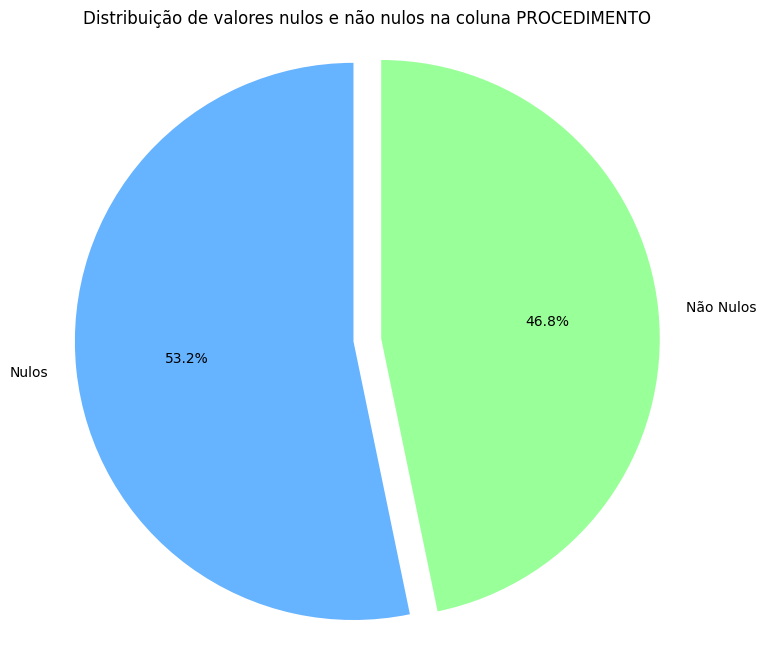

In [ ]:
# Contagem de valores nulos e não nulos na coluna 'PROCEDIMENTO'
contagem_valores = df_merged['PROCEDIMENTO'].isnull().value_counts()

# Criar um gráfico de pizza
labels = ['Nulos', 'Não Nulos']
colors = ['#66b3ff', '#99ff99']
explode = (0.1, 0)  # Explodir a primeira fatia (Não Nulos)

plt.pie(contagem_valores, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title('Distribuição de valores nulos e não nulos na coluna PROCEDIMENTO')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.

plt.show()

In [ ]:
contagem_procedimento = df_merged.groupby('Unnamed: 10')['PROCEDIMENTO'].count()

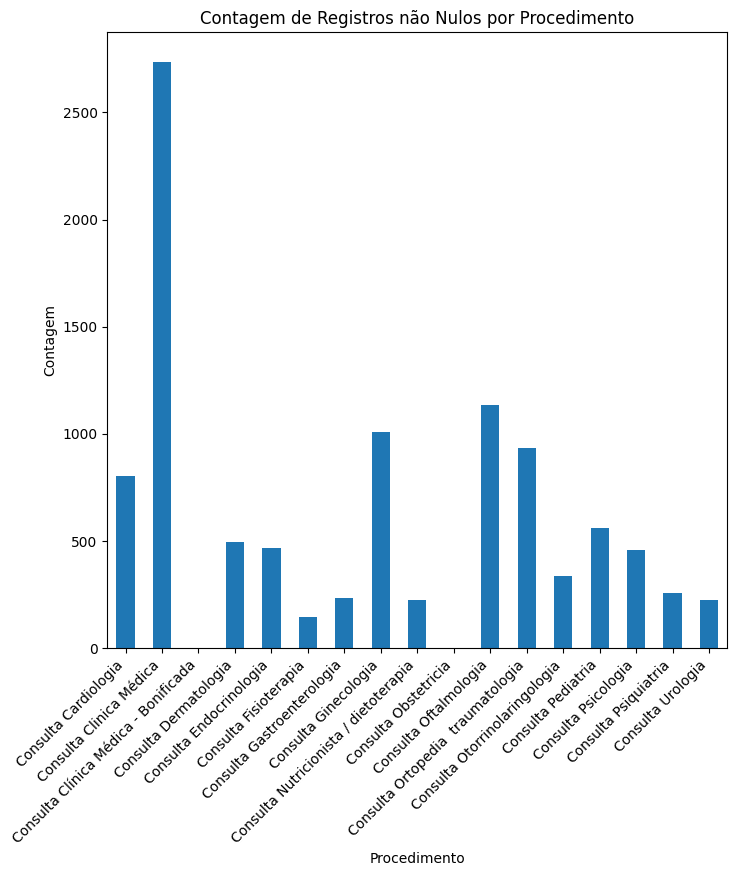

In [ ]:
contagem_procedimento = df_merged.groupby('PROCEDIMENTO').size()
contagem_procedimento.plot(kind='bar', rot=0)
plt.title('Contagem de Registros não Nulos por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.show()

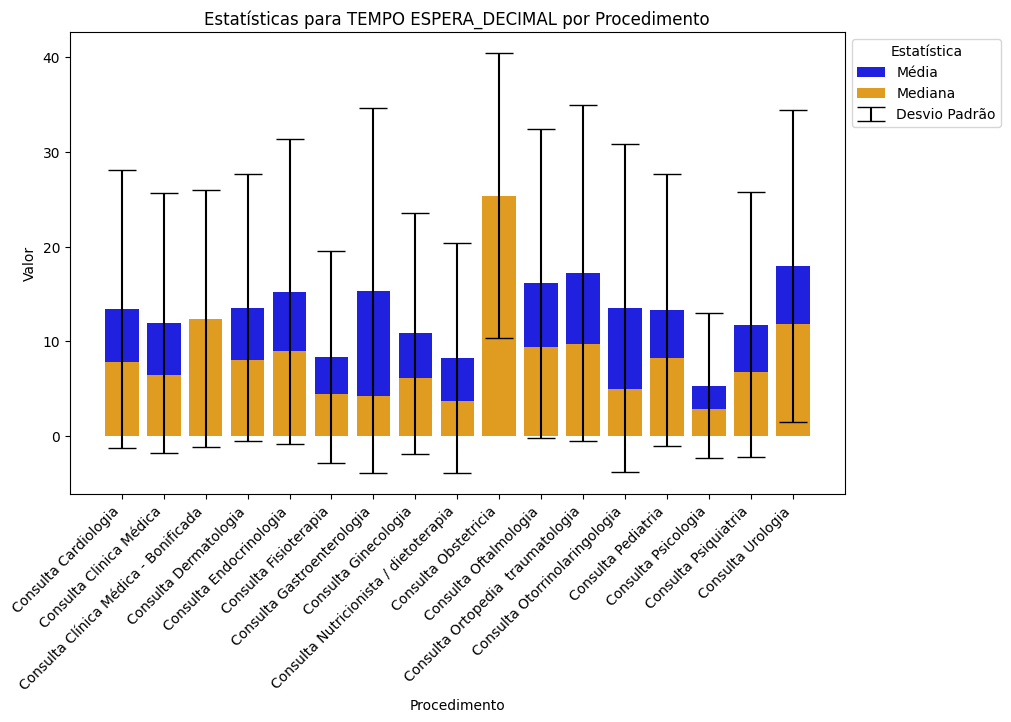

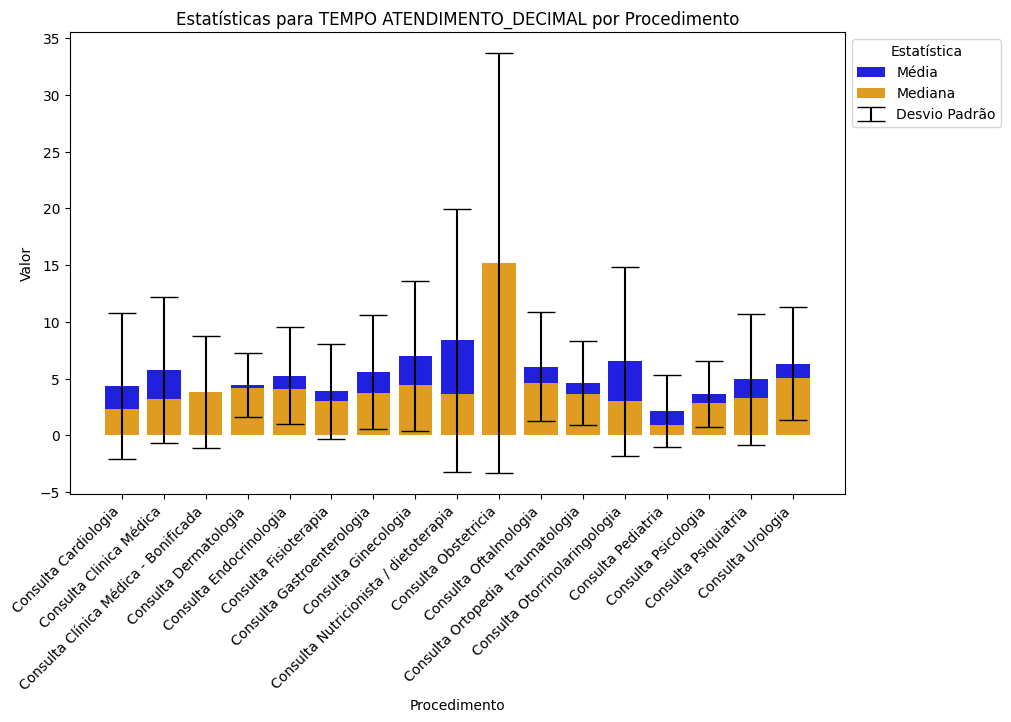

In [ ]:
# Calcular média, mediana e desvio padrão para TEMPO ESPERA_DECIMAL
estatisticas_tempo_espera = df_merged.groupby('PROCEDIMENTO')['TEMPO ESPERA_DECIMAL'].agg(['mean', 'median', 'std'])

# Calcular média, mediana e desvio padrão para TEMPO ATENDIMENTO_DECIMAL
estatisticas_tempo_atendimento = df_merged.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['mean', 'median', 'std'])

# Criar gráfico para TEMPO ESPERA_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_espera.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_espera.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_espera.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_espera['mean'], yerr=estatisticas_tempo_espera['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ESPERA_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

# Criar gráfico para TEMPO ATENDIMENTO_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_atendimento.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_atendimento.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_atendimento.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_atendimento['mean'], yerr=estatisticas_tempo_atendimento['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ATENDIMENTO_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

In [ ]:
df_merged = df_merged.dropna(subset=['PROCEDIMENTO'])
df_filtrado_outliers = df_merged[(df_merged['Unnamed: 10'] == 'GUICHÊS') | (df_merged['Unnamed: 10'] == 'TRIAGEM')]


In [ ]:
df_filtrado_outliers

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO
9,Jesuina Candida Da Silva,P1,MEDICO PREFERENCIAL,2023-09-01,07:35:15,00:00:07,00:05:27,00:05:34,Ivina Renata,GUICHÊS-02,GUICHÊS,7.587500,0.116667,5.450000,Consulta Cardiologia
18,Rita De Cassia Medeiros,M2,ATENDIMENTO MEDICO,2023-09-01,07:51:54,00:00:05,00:08:09,00:08:14,Ivina Renata,GUICHÊS-02,GUICHÊS,7.865000,0.083333,8.150000,Consulta Cardiologia
20,Catarina Da Silva Costa,M3,ATENDIMENTO MEDICO,2023-09-01,07:53:23,00:00:25,00:01:44,00:02:09,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,7.889722,0.416667,1.733333,Consulta Psicologia
30,Gilma Gomes Dos Reis Lopes,F2,FISIOTERAPIA,2023-09-01,08:19:07,00:00:09,00:02:41,00:02:50,Ivina Renata,GUICHÊS-02,GUICHÊS,8.318611,0.150000,2.683333,Consulta Fisioterapia
35,Nair Amaro Dos Reis Dias,M5,ATENDIMENTO MEDICO,2023-09-01,08:36:04,00:00:40,00:00:27,00:01:07,Ana Carolina Martins Andrade Gomes,GUICHÊS-1,GUICHÊS,8.601111,0.666667,0.450000,Consulta Cardiologia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21445,Clara Cruvinel,M200,ATENDIMENTO MEDICO,2023-10-31,16:37:17,00:00:09,00:02:27,00:02:36,Ivina Renata,GUICHÊS-01,GUICHÊS,16.621389,0.150000,2.450000,Consulta Ortopedia traumatologia
21448,Maria Madalena Da Silva Melo,M201,ATENDIMENTO MEDICO,2023-10-31,16:40:46,00:00:03,00:05:05,00:05:08,Ivina Renata,GUICHÊS-01,GUICHÊS,16.679444,0.050000,5.083333,Consulta Nutricionista / dietoterapia
21451,Cheyenne Mota De Lima,M203,ATENDIMENTO MEDICO,2023-10-31,16:44:31,00:01:39,00:03:43,00:05:22,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,16.741944,1.650000,3.716667,Consulta Oftalmologia
21453,Eli Vieira De Lima,M204,ATENDIMENTO MEDICO,2023-10-31,16:46:59,00:00:07,00:02:43,00:02:50,Taina Matias,GUICHÊS-2,GUICHÊS,16.783056,0.116667,2.716667,Consulta Ortopedia traumatologia


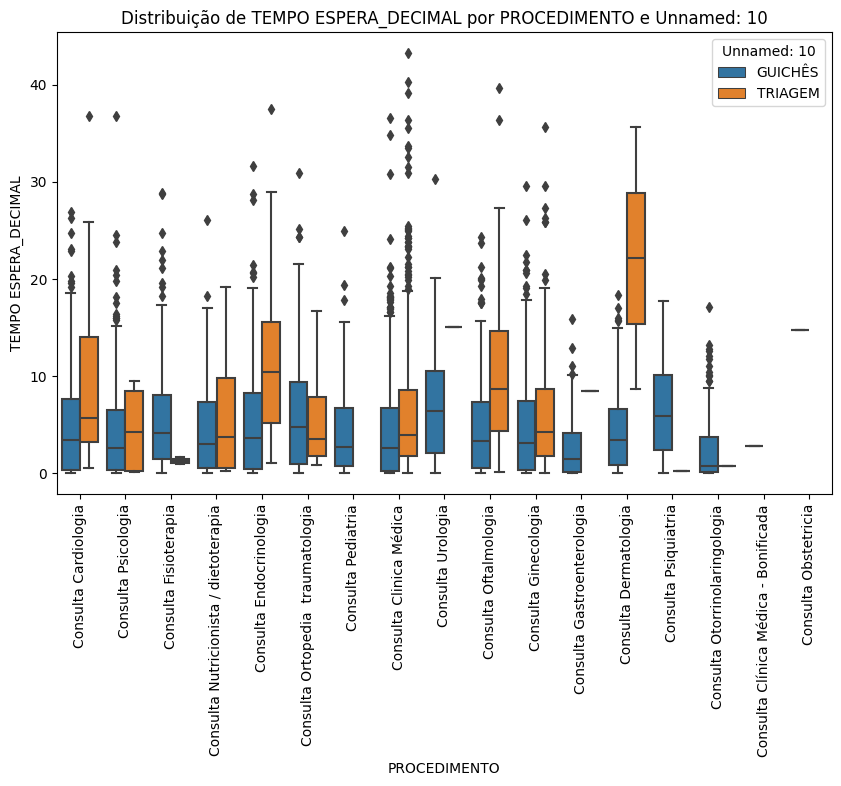

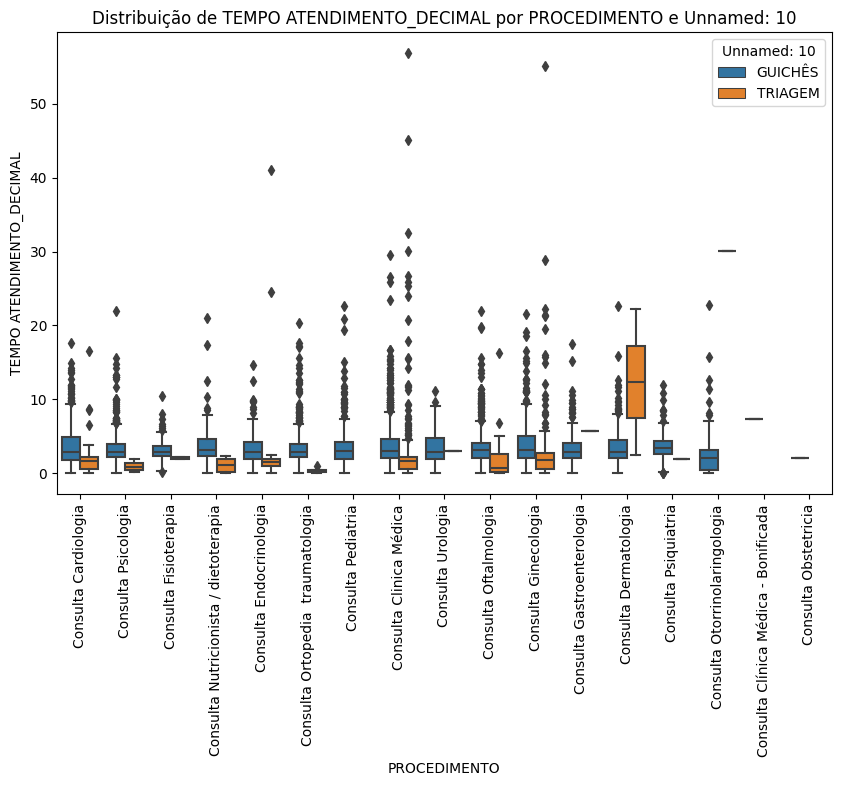

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x600 with 0 Axes>

In [ ]:
colunas_selecionadas = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL', 'PROCEDIMENTO', 'Unnamed: 10']
df_selecionado = df_filtrado_outliers[colunas_selecionadas]

# Crie gráficos de caixa individuais para cada coluna agrupada por 'PROCEDIMENTO' e 'Unnamed: 10'
for coluna in colunas_selecionadas[:-1]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='PROCEDIMENTO', y=coluna, hue='Unnamed: 10', data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por PROCEDIMENTO e Unnamed: 10')
    plt.xticks(rotation=90)  # Gira o eixo x em 90 graus
    plt.show()

In [ ]:
#pip install pyod

In [ ]:
from pyod.models.iforest import IForest

X = df_filtrado_outliers[['TEMPO ATENDIMENTO_DECIMAL']]

clf = IForest(contamination=0.05, random_state=42)

# Ajuste o modelo aos dados
clf.fit(X)

df_filtrado_outliers['outlier'] = clf.predict(X)

# Filtrar apenas os outliers na categoria 'Unnamed: 10'
outliers_unnamed10 = df_filtrado_outliers[df_filtrado_outliers['outlier'] == 1]

outliers_unnamed10

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO,outlier
117,Alexsander Raniere Mota,M28,DRA. POLIANA TOMAZ ROSA,2023-09-01,13:24:08,00:01:06,00:24:29,00:25:35,Millena Misael,TRIAGEM-1,TRIAGEM,13.402222,1.100000,24.483333,Consulta Endocrinologia,1
353,Leocadio Rosa De Jesus,M42,DRA. LUDIMILA VIANA,2023-09-02,09:43:53,00:12:18,00:25:49,00:38:07,Millena Misael,TRIAGEM-1,TRIAGEM,9.731389,12.300000,25.816667,Consulta Clinica Médica,1
452,Eliel Da Silva Honorio,M13,ATENDIMENTO MEDICO,2023-09-04,07:47:44,00:12:51,00:10:04,00:22:55,Ivina Renata,GUICHÊS-02,GUICHÊS,7.795556,12.850000,10.066667,Consulta Clinica Médica,1
601,Bianca Ferreira,M62,ATENDIMENTO MEDICO,2023-09-04,10:04:04,00:05:49,00:11:26,00:17:15,Ivina Renata,GUICHÊS-02,GUICHÊS,10.067778,5.816667,11.433333,Consulta Clinica Médica,1
624,Claudiana Genuino Dos Santos,M67,ATENDIMENTO MEDICO,2023-09-04,10:31:24,00:00:09,00:09:55,00:10:04,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,10.523333,0.150000,9.916667,Consulta Endocrinologia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21164,Genadir Jose Dias,P7,MEDICO PREFERENCIAL,2023-10-31,10:33:59,00:04:24,00:09:39,00:14:03,Ivina Renata,GUICHÊS-01,GUICHÊS,10.566389,4.400000,9.650000,Consulta Cardiologia,1
21165,Genadir Jose Dias,P7,MEDICO PREFERENCIAL,2023-10-31,10:33:59,00:04:24,00:09:39,00:14:03,Ivina Renata,GUICHÊS-01,GUICHÊS,10.566389,4.400000,9.650000,Consulta Dermatologia,1
21193,Rafael Oliveira De Souza,M106,ATENDIMENTO MEDICO,2023-10-31,11:06:08,00:02:19,00:22:35,00:24:54,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,11.102222,2.316667,22.583333,Consulta Dermatologia,1
21209,Marlene De Freitas Borges,M112,ATENDIMENTO MEDICO,2023-10-31,11:47:11,00:02:13,00:08:46,00:10:59,Ivina Renata,GUICHÊS-01,GUICHÊS,11.786389,2.216667,8.766667,Consulta Dermatologia,1


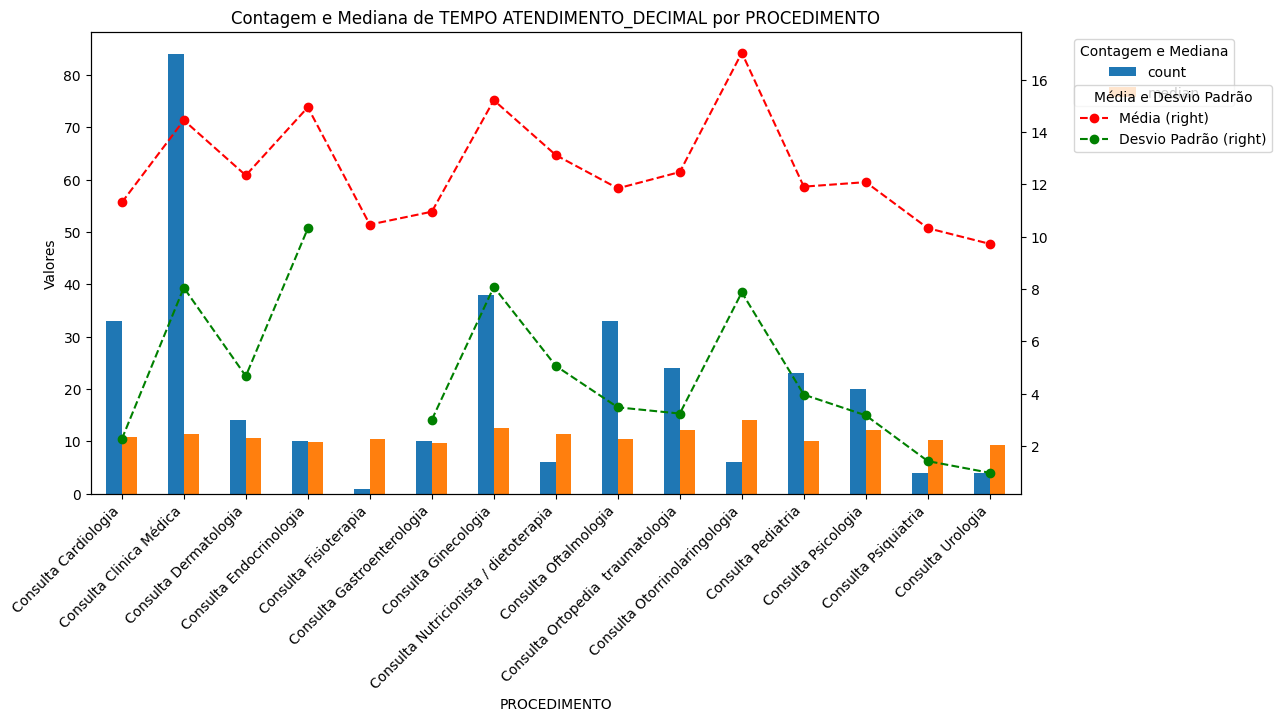

In [ ]:
summary_stats = outliers_unnamed10.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['count', 'median'])

# Calcula a média e o desvio padrão de TEMPO ATENDIMENTO_DECIMAL para cada PROCEDIMENTO
mean_std_stats = outliers_unnamed10.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['mean', 'std'])

# Cria o gráfico de barras para contagem e mediana
fig, ax = plt.subplots(figsize=(12, 6))
summary_stats.plot(kind='bar', ax=ax)
ax.set_title('Contagem e Mediana de TEMPO ATENDIMENTO_DECIMAL por PROCEDIMENTO')
ax.set_ylabel('Valores')

# Adiciona as linhas para média e desvio padrão
mean_std_stats['mean'].plot(ax=ax, linestyle='--', marker='o', color='red', secondary_y=True, label='Média')
mean_std_stats['std'].plot(ax=ax, linestyle='--', marker='o', color='green', secondary_y=True, label='Desvio Padrão')

# Rotaciona os rótulos do eixo x em 45 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adiciona as legendas
ax.legend(title='Contagem e Mediana', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.right_ax.legend(title='Média e Desvio Padrão', bbox_to_anchor=(1.05, 0.9), loc='upper left')


plt.show()

In [ ]:
from pyod.models.iforest import IForest


X = df_merged[['TEMPO ATENDIMENTO_DECIMAL']]

# Crie o modelo Isolation Forest do PyOD
clf = IForest(contamination=0.05, random_state=42)

# Ajuste o modelo aos dados
clf.fit(X)

# Adicione uma coluna 'outlier' indicando se cada ponto é um outlier ou não
df_merged['outlier'] = clf.predict(X)

# Filtrar apenas os outliers na categoria 'Unnamed: 10'
outliers_unnamed10 = df_merged[df_merged['outlier'] == 1]

outliers_unnamed10

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10,EMISSAO_DECIMAL,TEMPO ESPERA_DECIMAL,TEMPO ATENDIMENTO_DECIMAL,PROCEDIMENTO,outlier
101,Neusa Teles,M23,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,12:47:49,00:15:49,00:19:26,00:35:15,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,12.796944,15.816667,19.433333,Consulta Cardiologia,1
104,Berenice Vieira Freitas De Oliveira,P4,DRA. POLIANA TOMAZ ROSA,2023-09-01,12:55:04,00:03:23,00:17:35,00:20:58,Dra. Poliana Tomaz Rosa,CONSULTÓRIO-5,CONSULTÓRIO,12.917778,3.383333,17.583333,Consulta Endocrinologia,1
113,Antonia Joselina Rosa,M27,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,13:10:52,00:12:23,00:26:14,00:38:37,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,13.181111,12.383333,26.233333,Consulta Cardiologia,1
117,Alexsander Raniere Mota,M28,DRA. POLIANA TOMAZ ROSA,2023-09-01,13:24:08,00:01:06,00:24:29,00:25:35,Millena Misael,TRIAGEM-1,TRIAGEM,13.402222,1.100000,24.483333,Consulta Endocrinologia,1
144,Laiany Fatima Barcelos Dos Reis,M31,DRA. ROSELI MARIA DE OLIVEIRA,2023-09-01,13:33:03,00:01:08,00:23:24,00:24:32,Dra. Roseli Maria De Oliveira Carvalho\t,CONSULTÓRIO-6,CONSULTÓRIO,13.550833,1.133333,23.400000,Consulta Cardiologia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20873,Celma De Fatima Mota,M88,DR.FRANSERGIO FERREIRA,2023-10-30,15:52:56,00:04:05,00:20:25,00:24:30,Dr. Fransergio Ferreira,CONSULTÓRIO-1,CONSULTÓRIO,15.882222,4.083333,20.416667,Consulta Clinica Médica,1
21116,Bruno Ricardo De Castro Vieira,M68,DRA. MILENA BRASILEIRO,2023-10-31,09:49:19,00:52:54,00:16:59,01:09:53,Dra. Milena Brasileiro,CONSULTÓRIO-6,CONSULTÓRIO,9.821944,52.900000,16.983333,Consulta Psiquiatria,1
21193,Rafael Oliveira De Souza,M106,ATENDIMENTO MEDICO,2023-10-31,11:06:08,00:02:19,00:22:35,00:24:54,Kamila Rodrigues,GUICHÊS-3,GUICHÊS,11.102222,2.316667,22.583333,Consulta Dermatologia,1
21243,Raymunda Porcino De Barros Couto,M126,DRA. ANNELISE DE MACEDO,2023-10-31,13:40:18,00:41:57,00:17:15,00:59:12,Dra. Annelise de Macedo,CONSULTÓRIO-7,CONSULTÓRIO,13.671667,41.950000,17.250000,Consulta Oftalmologia,1
